In [10]:
import re
import pandas as pd

def extract_results(file_path,start):
    pattern = re.compile(r"The file (.*?) returned (.*?) in time (.*?)!")
    data = []
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith(start):
                match = pattern.search(line)
                if match:
                    file_name, result, time_limit = match.groups()
                    data.append((file_name, result, time_limit))

    pattern = re.compile(r"The file (.*?) timed out in time (.*?)!")
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith(start):
                match = pattern.search(line)
                if match:
                    file_name, time_limit = match.groups()
                    data.append((file_name, "TIMEOUT", time_limit)) 
    
    df = pd.DataFrame(data, columns=["file_name", "result", "time_limit"])
    return df

gbc_df = extract_results("slurm-29516543.out", "1.")

# The file ae9522ea003ea9f75891b2d37a5e264b-srhd-sgi-m37-q446.25-n35-p30-s33692332.cnf returned SAT in time 4.4467597007751465!

print(gbc_df.to_string())

                                                                                                                   file_name                     result            time_limit
0                                                                           ef330d1b144055436a2d576601191ea5-crn_11_99_u.cnf                      UNSAT     9.137923240661621
1                                                               46d75199933980fdb856f13e5b1817dd-1-TC-256-K-64.sanitized.cnf  a non-zero exit -6 status    300.32532501220703
2                                                                edceb8782e72e290fa54757dbfdd0173-x9-09057.sat.sanitized.cnf                      UNSAT     402.2980101108551
3                                                    70ef2b6bdc4101a0e35cf3d165571fe3-qwh.50.1250.shuffled-as.sat03-1655.cnf                        SAT      738.501430273056
4                                                                  c5ae0ec49de0959cd14431ce851c14f8-Circuit_multiplier22.cnf      

In [11]:
no_gbc_df = extract_results("slurm-29516543.out", "2.")
print(no_gbc_df.to_string())

                                                                                                                   file_name                    result             time_limit
0                                                                           ef330d1b144055436a2d576601191ea5-crn_11_99_u.cnf                     UNSAT      7.376698970794678
1                                                                edceb8782e72e290fa54757dbfdd0173-x9-09057.sat.sanitized.cnf                     UNSAT     375.36069917678833
2                                                    70ef2b6bdc4101a0e35cf3d165571fe3-qwh.50.1250.shuffled-as.sat03-1655.cnf                       SAT      224.8674235343933
3                                                                  c5ae0ec49de0959cd14431ce851c14f8-Circuit_multiplier22.cnf                       SAT      707.7964084148407
4                                                                d195412a62cdcbb851136f60af76f463-x9-09098.sat.sanitized.cnf      

In [12]:
merged_df = no_gbc_df.merge(gbc_df, on='file_name', suffixes=('_no_gbc', '_gbc'))

print(merged_df.to_string())

                                                                                                                   file_name             result_no_gbc      time_limit_no_gbc                 result_gbc        time_limit_gbc
0                                                                           ef330d1b144055436a2d576601191ea5-crn_11_99_u.cnf                     UNSAT      7.376698970794678                      UNSAT     9.137923240661621
1                                                                edceb8782e72e290fa54757dbfdd0173-x9-09057.sat.sanitized.cnf                     UNSAT     375.36069917678833                      UNSAT     402.2980101108551
2                                                    70ef2b6bdc4101a0e35cf3d165571fe3-qwh.50.1250.shuffled-as.sat03-1655.cnf                       SAT      224.8674235343933                        SAT      738.501430273056
3                                                                  c5ae0ec49de0959cd14431ce851c14f8-Circuit_

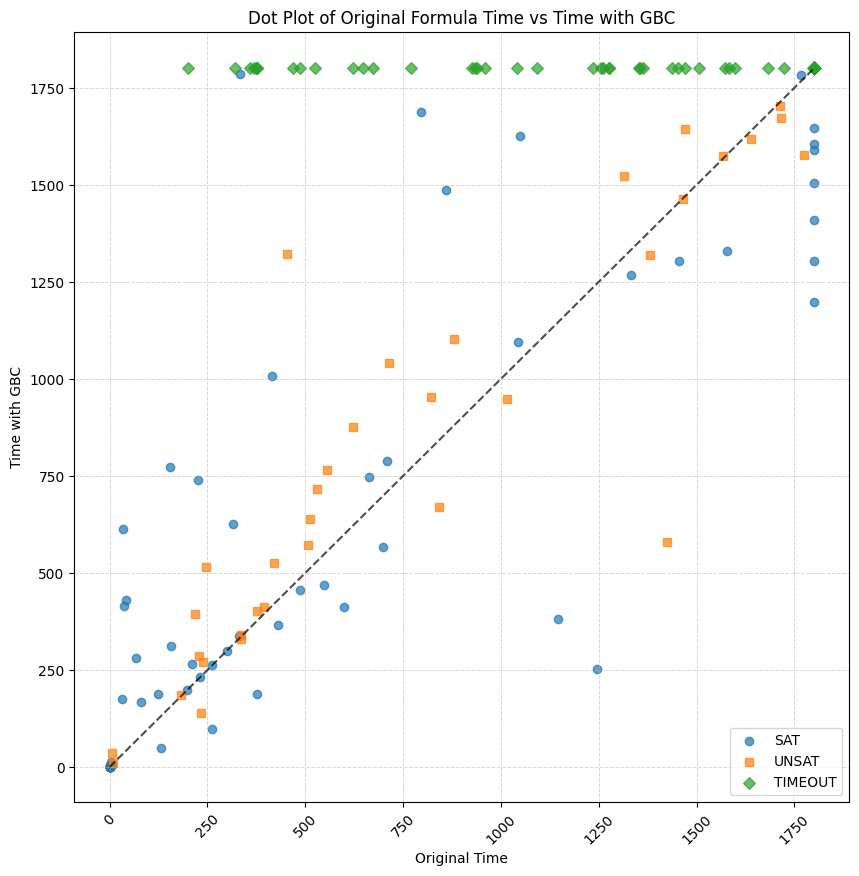

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to generate dot plot
def plot_dot_chart(result_df):
    plt.figure(figsize=(10, 10))
    
    # Define marker styles for different results
    marker_styles = {'SAT': 'o', 'UNSAT': 's', 'TIMEOUT': 'D'}
    
    # Create plot with different colors and markers
    for result_type, marker in marker_styles.items():
        subset = result_df[result_df['result_gbc'] == result_type]
        plt.scatter(pd.to_numeric(subset['time_limit_no_gbc']), pd.to_numeric(subset['time_limit_gbc']), label=result_type, marker=marker, alpha=0.7)
    
    # Set axis labels and title
    plt.xlabel('Original Time')
    plt.ylabel(f'Time with GBC')
    plt.title(f'Dot Plot of Original Formula Time vs Time with GBC')
    
    # Adjust x-axis and y-axis scales to show proper numbers
    plt.xticks(rotation=45)
    plt.yticks()
    
    # Add an x=y reference line
    # min_val = min(result_df['original_time'].min(), result_df['min_time'].min())
    # max_val = max(result_df['original_time'].max(), result_df['min_time'].max())
    plt.plot([0, 1800], [0, 1800], linestyle='--', color='black', alpha=0.7, label='')
    
    # Customize grid
    plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.7)
    plt.legend()
    # plt.show()
    plt.savefig(f'cadical_vs_cadical_gbc_time_gbc_3.8.png')

plot_dot_chart(merged_df)

In [25]:
improved_df = merged_df[
    (pd.to_numeric(merged_df['time_limit_gbc']) <= 0.8 * pd.to_numeric(merged_df['time_limit_no_gbc'])) &
    (merged_df['result_gbc'].isin(['SAT', 'UNSAT']))
]

print(improved_df.to_string())

                                                                                                file_name result_no_gbc   time_limit_no_gbc result_gbc      time_limit_gbc
24                                      a38affaa741c958fc32769d5fe89b06c-frb65-12-2.used-as.sat04-874.cnf           SAT   261.4643633365631        SAT    97.6516604423523
36                                            3a75ad246dbc750a7391ad887c5b0835-x9-11093.sat.sanitized.cnf           SAT  1246.2681241035461        SAT  252.96102213859558
37                                               50019e4419d48196bb4b95933a8b5030-noL-11-14.sanitized.cnf           SAT   1144.640493631363        SAT  382.07967019081116
39                                            915a25bd189357e4c6d7771b69a6849f-x9-09004.sat.sanitized.cnf         UNSAT   842.1606323719025      UNSAT   669.5578818321228
44                                            c5a98231dd54cbca06135293bb7e1985-x9-11053.sat.sanitized.cnf           SAT    598.113231420517      

In [1]:
%history -g

 1/1:
from debugger.proof_analyzer import ProofAnalyzer
from debugger.tree_parser import *
 1/2: p = ProofAnalyzer("example_proof_4.13.0.proof")
 1/3: p = ProofAnalyzer("../example_proof_4.13.0.proof")
 1/4: print(p.get_qi_counts())
 1/5:
qi_counts = p.get_qi_counts()

print(qi_counts)
print(sum(qi_counts.values()))
 1/6: p = ProofAnalyzer("../example_proof_4.8.5.proof")
 1/7: p = ProofAnalyzer("../example_proof_4.8.5.proof")
 1/8:
qi_counts = p.get_qi_counts()

print(qi_counts)
print(sum(qi_counts.values()))
 1/9: p = ProofAnalyzer("../example_proof_4.8.5.proof")
1/10: p = ProofAnalyzer("../example_proof_4.8.5.proof")
1/11: p = ProofAnalyzer("../example_proof_4.8.5.proof")
1/12:
from debugger.proof_analyzer import ProofAnalyzer
from debugger.tree_parser import *
1/13: p = ProofAnalyzer("../example_proof_4.8.5.proof")
 3/1:
from debugger.proof_analyzer import ProofAnalyzer
from debugger.tree_parser import *
 3/2: p = ProofAnalyzer("../example_proof_4.8.5.proof")
 3/3: p = ProofAnalyzer